This notebook approximates neural networks to simulated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt



# Geometric Brownian Motion (Black Scholes)

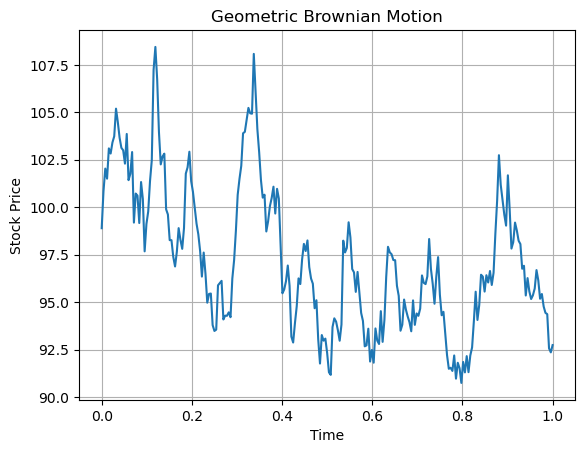

In [2]:


def simulate_geometric_brownian_motion(mu, sigma, S0, T, N):
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1)
    W = np.cumsum(W) * np.sqrt(dt)  # standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # geometric Brownian motion
    return t, S

# Function to simulate European call options based on CBOE rules
def simulate_cboe_options(S0, strikes, T, r, sigma):
    call_prices = {}
    for K in strikes:
        call_price = black_scholes_call(S0, K, T, r, sigma)
        call_prices[K] = call_price
    return call_prices

# Function to calculate the Black-Scholes call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Parameters
mu = 0.05  # drift
sigma = 0.2  # volatility
S0 = 100  # initial stock price
T = 1  # time horizon
N = 252  # number of time steps

# Simulate geometric Brownian motion
t, S = simulate_geometric_brownian_motion(mu, sigma, S0, T, N)

# Plot the results
plt.plot(t, S)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion')
plt.grid(True)
plt.show()
